## Import the Required Libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Reading the data

In [2]:
raw_data=pd.read_csv("Data/solar2022.csv")

In [ ]:
raw_data.head()

,Source,Location ID,City,State,Country,Latitude,Longitude,Time Zone,Elevation,Local Time Zone,Clearsky DHI Units,Clearsky DNI Units,Clearsky GHI Units,Dew Point Units,DHI Units,DNI Units,GHI Units,Solar Zenith Angle Units,Temperature Units,Pressure Units,Relative Humidity Units,Precipitable Water Units,Wind Direction Units,Wind Speed Units,Cloud Type -15,Cloud Type 0,Cloud Type 1,Cloud Type 2,Cloud Type 3,Cloud Type 4,Cloud Type 5,Cloud Type 6,Cloud Type 7,Cloud Type 8,Cloud Type 9,Cloud Type 10,Cloud Type 11,Cloud Type 12,Fill Flag 0,Fill Flag 1,Fill Flag 2,Fill Flag 3,Fill Flag 4,Fill Flag 5,Surface Albedo Units,Version
0,NSRDB,223700,-,-,-,40.97,-4.54,1,895,1,w/m2,w/m2,w/m2,c,w/m2,w/m2,w/m2,Degree,c,mbar,%,cm,Degrees,m/s,NaN,Clear,Probably Clear,Fog,Water,Super-Cooled Water,Mixed,Opaque Ice,Cirrus,Overlapping,Overshooting,Unknown,Dust,Smoke,NaN,Missing Image,Low Irradiance,Exceeds Clearsky,Missing CLoud Properties,Rayleigh Violation,NaN,4.0.0
1,Year,Month,Day,Hour,Minute,Temperature,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,Relative Humidity,Pressure,Wind Direction,Wind Speed,DHI,DNI,GHI,Solar Zenith Angle,Precipitable Water,Surface Albedo,Fill Flag,Dew Point,Asymmetry,Aerosol Optical Depth,Alpha,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022,1,1,0,30,4.9,0,0,0,1,69.27,914,172,3.4000000000000004,0,0,0,159.08,1.4000000000000001,0.17,0,-0.30000000000000004,0.67,0.07100000000000001,0.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022,1,1,1,30,5.2,0,0,0,4,57.26,918,183,1.6,0,0,0,161.96,0.5,0.16,0,-2.6,0.64,0.011,1.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022,1,1,2,30,5.300000000000001,0,0,0,0,55.49,919,184,1.5,0,0,0,157,0.5,0.16,0,-2.9000000000000004,0.64,0.011,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data_info= raw_data.loc[0]

In [ ]:
print(data_info)

Source                                         NSRDB
Location ID                                   223700
City                                               -
State                                              -
Country                                            -
Latitude                                       40.97
Longitude                                      -4.54
Time Zone                                          1
Elevation                                        895
Local Time Zone                                    1
Clearsky DHI Units                              w/m2
Clearsky DNI Units                              w/m2
Clearsky GHI Units                              w/m2
Dew Point Units                                    c
DHI Units                                       w/m2
DNI Units                                       w/m2
GHI Units                                       w/m2
Solar Zenith Angle Units                      Degree
Temperature Units                             

## Details about the columns 
- Timestamp : The specific date and time for each 30-minute observation.
- GHI,Global Horizontal Irradiance: The total amount of shortwave radiation received from above by a surface horizontal to the ground (W/m²).
- DNI,Direct Normal Irradiance: The amount of solar radiation received per unit area by a surface that is always held perpendicular (or normal) to the rays that come in a straight line from the direction of the sun (W/m²).
- DHI,Diffuse Horizontal Irradiance: The radiation received from the sky (after being scattered by the atmosphere) on a horizontal surface (W/m²).
- Temperature: Ambient air temperature measured in degrees Celsius (°C).
- Relative Humidity: The ratio of the current absolute humidity to the highest possible absolute humidity (expressed as a percentage).
- Pressure: The force exerted by the weight of the atmosphere, measured in hectopascals or millibars (hPa).
- Wind Speed : The rate at which air is moving past a certain point (m/s).
- Solar Zenith Angle: The angle between the sun's rays and the vertical direction (90° means the sun is at the horizon).
- Precipitable Water: The depth of liquid water that would result if all the water vapor in a vertical column of the atmosphere were condensed (cm).
- Dew Point: The atmospheric temperature below which water droplets begin to condense and dew can form (°C).
-Season: "Categorical classification (Spring, Summer, Autumn, Winter) derived from the specific month of the observation."

## Seperating the detils row and the data 

In [3]:
data=pd.read_csv("data/solar2022.csv",skiprows = 2)

In [4]:
data.head()

,Year,Month,Day,Hour,Minute,Temperature,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,Relative Humidity,Pressure,Wind Direction,Wind Speed,DHI,DNI,GHI,Solar Zenith Angle,Precipitable Water,Surface Albedo,Fill Flag,Dew Point,Asymmetry,Aerosol Optical Depth,Alpha
0,2022,1,1,0,30,4.9,0,0,0,1,69.27,914,172,3.4,0,0,0,159.08,1.4,0.17,0,-0.3,0.67,0.071,0.40
1,2022,1,1,1,30,5.2,0,0,0,4,57.26,918,183,1.6,0,0,0,161.96,0.5,0.16,0,-2.6,0.64,0.011,1.02
2,2022,1,1,2,30,5.3,0,0,0,0,55.49,919,184,1.5,0,0,0,157.00,0.5,0.16,0,-2.9,0.64,0.011,1.04
3,2022,1,1,3,30,5.3,0,0,0,0,54.39,919,184,1.5,0,0,0,147.66,0.5,0.16,0,-3.2,0.64,0.011,1.07
4,2022,1,1,4,30,5.3,0,0,0,4,53.39,919,184,1.4,0,0,0,136.82,0.5,0.16,0,-3.4,0.64,0.011,1.08


In [ ]:
data.tail()

,Year,Month,Day,Hour,Minute,Temperature,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,Relative Humidity,Pressure,Wind Direction,Wind Speed,DHI,DNI,GHI,Solar Zenith Angle,Precipitable Water,Surface Albedo,Fill Flag,Dew Point,Asymmetry,Aerosol Optical Depth,Alpha
8755,2022,12,31,19,30,6.2,0,0,0,3,66.17,914,176,3.5,0,0,0,106.46,1.4,0.17,0,0.4,0.67,0.052,0.31
8756,2022,12,31,20,30,5.7,0,0,0,4,68.11,915,174,3.4,0,0,0,117.52,1.4,0.17,0,0.3,0.67,0.055,0.32
8757,2022,12,31,21,30,5.3,0,0,0,4,69.63,915,173,3.2,0,0,0,128.81,1.4,0.17,0,0.2,0.67,0.060,0.32
8758,2022,12,31,22,30,5.0,0,0,0,1,70.24,914,173,3.3,0,0,0,140.02,1.4,0.17,0,0.0,0.67,0.064,0.34
8759,2022,12,31,23,30,4.9,0,0,0,8,69.86,914,172,3.4,0,0,0,150.59,1.4,0.17,0,-0.1,0.67,0.068,0.37


In [ ]:
data.shape

(8760, 25)

In [ ]:
data.head()

,Year,Month,Day,Hour,Minute,Temperature,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,Relative Humidity,Pressure,Wind Direction,Wind Speed,DHI,DNI,GHI,Solar Zenith Angle,Precipitable Water,Surface Albedo,Fill Flag,Dew Point,Asymmetry,Aerosol Optical Depth,Alpha
0,2022,1,1,0,30,4.9,0,0,0,1,69.27,914,172,3.4,0,0,0,159.08,1.4,0.17,0,-0.3,0.67,0.071,0.40
1,2022,1,1,1,30,5.2,0,0,0,4,57.26,918,183,1.6,0,0,0,161.96,0.5,0.16,0,-2.6,0.64,0.011,1.02
2,2022,1,1,2,30,5.3,0,0,0,0,55.49,919,184,1.5,0,0,0,157.00,0.5,0.16,0,-2.9,0.64,0.011,1.04
3,2022,1,1,3,30,5.3,0,0,0,0,54.39,919,184,1.5,0,0,0,147.66,0.5,0.16,0,-3.2,0.64,0.011,1.07
4,2022,1,1,4,30,5.3,0,0,0,4,53.39,919,184,1.4,0,0,0,136.82,0.5,0.16,0,-3.4,0.64,0.011,1.08


In [ ]:
data.dtypes

Year                       int64
Month                      int64
Day                        int64
Hour                       int64
Minute                     int64
Temperature              float64
Clearsky DHI               int64
Clearsky DNI               int64
Clearsky GHI               int64
Cloud Type                 int64
Relative Humidity        float64
Pressure                   int64
Wind Direction             int64
Wind Speed               float64
DHI                        int64
DNI                        int64
GHI                        int64
Solar Zenith Angle       float64
Precipitable Water       float64
Surface Albedo           float64
Fill Flag                  int64
Dew Point                float64
Asymmetry                float64
Aerosol Optical Depth    float64
Alpha                    float64
dtype: object

## Combining the year, month, day, hour and minute as a single time stamp Feature and removing unwanted columns

In [9]:
data['Timestamp']=pd.to_datetime(data[['Year', 'Month', 'Day', 'Hour', 'Minute']])

In [10]:
data.set_index('Timestamp', inplace=True)

In [ ]:
data=data.sort_index()

In [11]:
data = data.drop(columns=['Year', 'Minute'])

In [12]:
data.head()

,Month,Day,Hour,Temperature,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,Relative Humidity,Pressure,Wind Direction,Wind Speed,DHI,DNI,GHI,Solar Zenith Angle,Precipitable Water,Surface Albedo,Fill Flag,Dew Point,Asymmetry,Aerosol Optical Depth,Alpha
Timestamp,,,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:30:00,1,1,0,4.9,0,0,0,1,69.27,914,172,3.4,0,0,0,159.08,1.4,0.17,0,-0.3,0.67,0.071,0.40
2022-01-01 01:30:00,1,1,1,5.2,0,0,0,4,57.26,918,183,1.6,0,0,0,161.96,0.5,0.16,0,-2.6,0.64,0.011,1.02
2022-01-01 02:30:00,1,1,2,5.3,0,0,0,0,55.49,919,184,1.5,0,0,0,157.00,0.5,0.16,0,-2.9,0.64,0.011,1.04
2022-01-01 03:30:00,1,1,3,5.3,0,0,0,0,54.39,919,184,1.5,0,0,0,147.66,0.5,0.16,0,-3.2,0.64,0.011,1.07
2022-01-01 04:30:00,1,1,4,5.3,0,0,0,4,53.39,919,184,1.4,0,0,0,136.82,0.5,0.16,0,-3.4,0.64,0.011,1.08


## Data Preprocessing

In [13]:
data.isnull().sum()

Month                    0
Day                      0
Hour                     0
Temperature              0
Clearsky DHI             0
Clearsky DNI             0
Clearsky GHI             0
Cloud Type               0
Relative Humidity        0
Pressure                 0
Wind Direction           0
Wind Speed               0
DHI                      0
DNI                      0
GHI                      0
Solar Zenith Angle       0
Precipitable Water       0
Surface Albedo           0
Fill Flag                0
Dew Point                0
Asymmetry                0
Aerosol Optical Depth    0
Alpha                    0
dtype: int64

In [ ]:
data.duplicated().sum()

np.int64(0)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2022-01-01 00:30:00 to 2022-12-31 23:30:00
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Month                  8760 non-null   int64  
 1   Day                    8760 non-null   int64  
 2   Hour                   8760 non-null   int64  
 3   Temperature            8760 non-null   float64
 4   Clearsky DHI           8760 non-null   int64  
 5   Clearsky DNI           8760 non-null   int64  
 6   Clearsky GHI           8760 non-null   int64  
 7   Cloud Type             8760 non-null   int64  
 8   Relative Humidity      8760 non-null   float64
 9   Pressure               8760 non-null   int64  
 10  Wind Direction         8760 non-null   int64  
 11  Wind Speed             8760 non-null   float64
 12  DHI                    8760 non-null   int64  
 13  DNI                    8760 non-null   int64  
 14  GHI                 

In [ ]:
data.describe()

,Month,Day,Hour,Temperature,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,Relative Humidity,Pressure,Wind Direction,Wind Speed,DHI,DNI,GHI,Solar Zenith Angle,Precipitable Water,Surface Albedo,Fill Flag,Dew Point,Asymmetry,Aerosol Optical Depth,Alpha
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,6.526027,15.720548,11.500000,13.501747,38.967237,370.407078,240.614155,2.901027,64.449428,910.432877,184.256279,2.454897,64.273516,206.956050,183.587900,89.662905,1.454726,0.192493,0.600571,5.160194,0.647534,0.079185,0.964078
std,3.448048,8.796749,6.922582,9.172793,49.824015,405.005444,315.734227,3.098291,25.658662,5.348741,93.642800,1.474911,106.461261,341.518533,277.095836,35.650100,0.578794,0.021698,2.006423,4.504840,0.012385,0.082760,0.363276
min,1.000000,1.000000,0.000000,-4.800000,0.000000,0.000000,0.000000,0.000000,6.510000,887.000000,1.000000,0.100000,0.000000,0.000000,0.000000,17.650000,0.200000,0.150000,0.000000,-11.600000,0.630000,0.010000,0.010000
25%,4.000000,8.000000,5.750000,6.300000,0.000000,0.000000,0.000000,0.000000,43.570000,907.000000,122.000000,1.300000,0.000000,0.000000,0.000000,62.140000,1.100000,0.170000,0.000000,2.400000,0.640000,0.031000,0.770000
50%,7.000000,16.000000,11.500000,12.100000,0.000000,0.000000,0.000000,1.000000,66.325000,911.000000,188.000000,2.100000,0.000000,0.000000,0.000000,89.205000,1.400000,0.200000,0.000000,5.800000,0.640000,0.055000,1.020000
75%,10.000000,23.000000,17.250000,19.900000,71.000000,823.000000,469.000000,6.000000,87.960000,914.000000,260.000000,3.400000,84.000000,310.000000,323.000000,117.365000,1.800000,0.210000,0.000000,8.400000,0.660000,0.089000,1.200000
max,12.000000,31.000000,23.000000,39.100000,343.000000,1027.000000,1031.000000,9.000000,100.000000,923.000000,360.000000,9.200000,544.000000,1027.000000,1031.000000,162.260000,3.500000,0.220000,8.000000,17.300000,0.670000,0.864000,1.980000


## Calculate the correlation matrix for the dataset and provide a brief description and interpretation of the results.

Text(0.5, 1.0, 'Correlation Heatmap ')

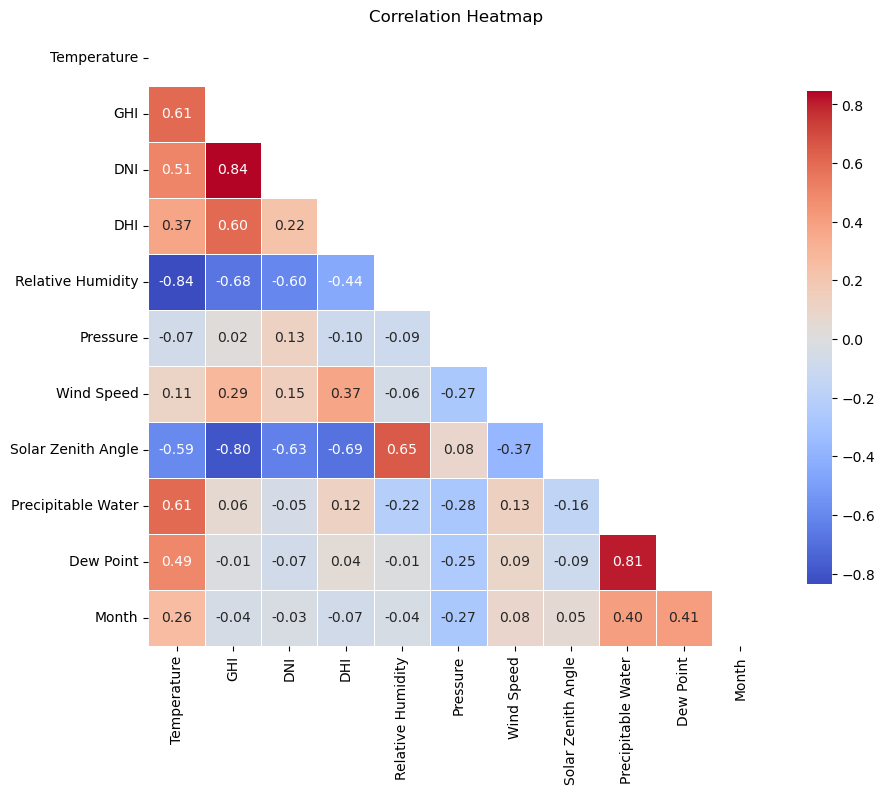

In [ ]:
cols_to_corr = ['Temperature', 'GHI', 'DNI', 'DHI', 'Relative Humidity', 'Pressure', 
                'Wind Speed', 'Solar Zenith Angle', 'Precipitable Water', 'Dew Point','Month']
corr_matrix = data[cols_to_corr].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, 
            mask=mask, 
            annot=True, 
            cmap='coolwarm', 
            fmt=".2f", 
            linewidths=0.5,
            cbar_kws={"shrink": .8})

plt.title('Correlation Heatmap ')

### Based on the correlation heatmap, several strong relationships are evident: Direct Normal Irradiance (DNI) and Global Horizontal Irradiance (GHI) show a high positive correlation, as do Precipitable Water and Dew Point. Furthermore, significant positive associations are observed between Temperature and GHI, as well as between Precipitable Water and Temperature.

## Plot the distribution of Global Horizontal Irradiance (GHI) with frequency 

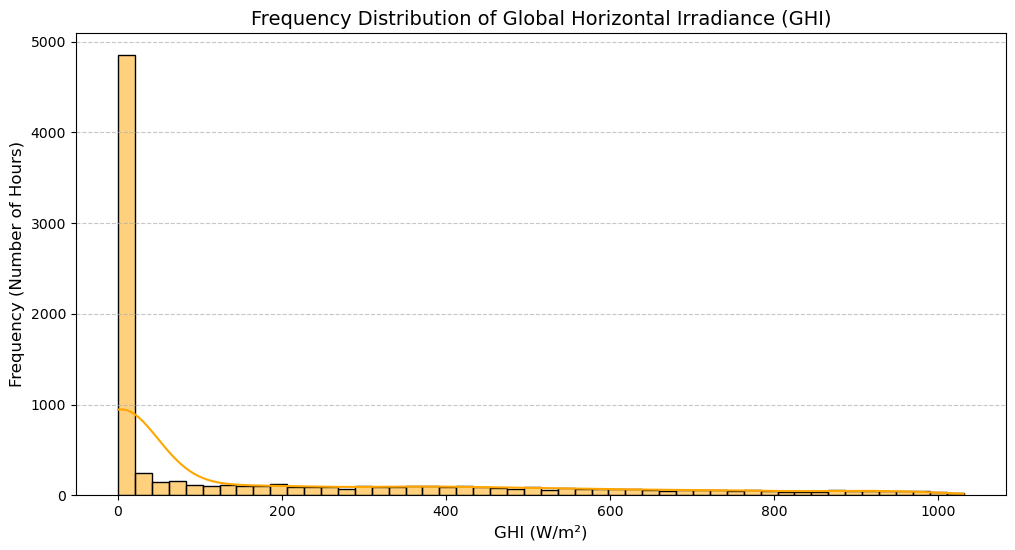

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(data['GHI'], bins=50, kde=True, color='orange')
plt.title('Frequency Distribution of Global Horizontal Irradiance (GHI)', fontsize=14)
plt.xlabel('GHI (W/m²)', fontsize=12)
plt.ylabel('Frequency (Number of Hours)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### The histogram demonstrates that GHI remains at zero during nighttime hours, while daytime peaks exceed 1000 W/m². This distribution confirms the consistent receipt of high-intensity solar radiation at this location

## Separate the data into seasons and clearly specify the date range by season

In [ ]:
# Defining the seasonal mapping function
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

# Applying the mapping to the dataframe
data['Season'] = data['Month'].apply(get_season)

In [ ]:
# To verify, we can check the number of hours in each season
print(data['Season'].value_counts())

Season
Spring    2208
Summer    2208
Autumn    2184
Winter    2160
Name: count, dtype: int64


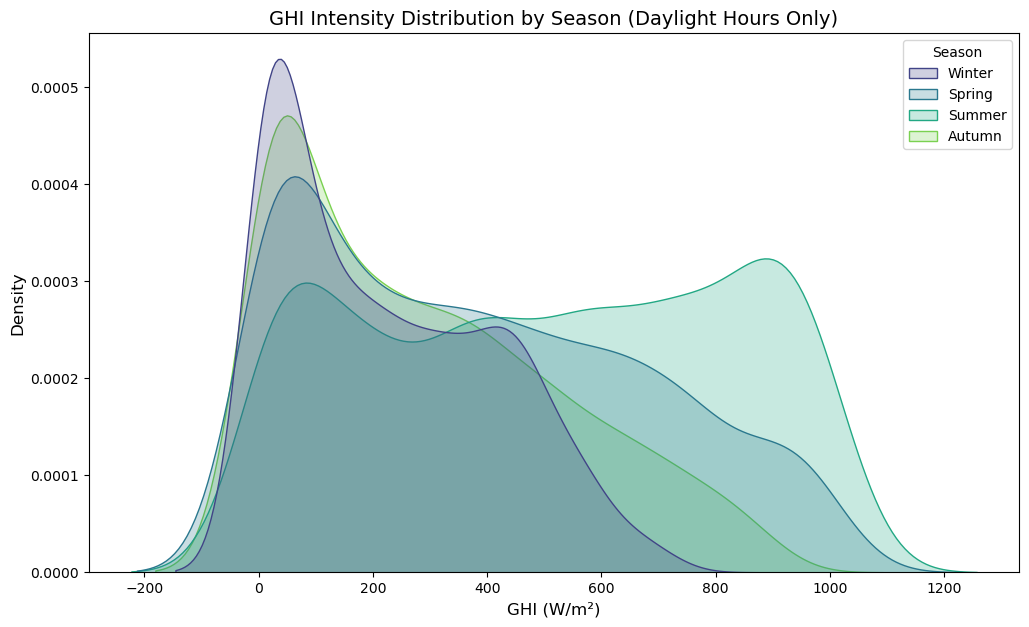

In [ ]:
plt.figure(figsize=(12, 7))
sns.kdeplot(data=data[data['GHI'] > 0], x='GHI', hue='Season', fill=True, palette='viridis')
plt.title('GHI Intensity Distribution by Season (Daylight Hours Only)', fontsize=14)
plt.xlabel('GHI (W/m²)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.show()

## Calculate the average GHI for each season and summarize the findings.

In [ ]:
data.groupby('Season')['GHI'].mean()

Season
Autumn    131.943223
Spring    205.612319
Summer    305.349185
Winter     88.825463
Name: GHI, dtype: float64

### From the mean values group by different season we can see that summer has high GHI

## Determine the amount of sunlight received at each hour of the day, create an appropriate plot, and explain the figure in one paragraph (what it shows and the reasons behind the observed trend).

In [ ]:
hourly_profile = data.groupby('Hour')['GHI'].mean()

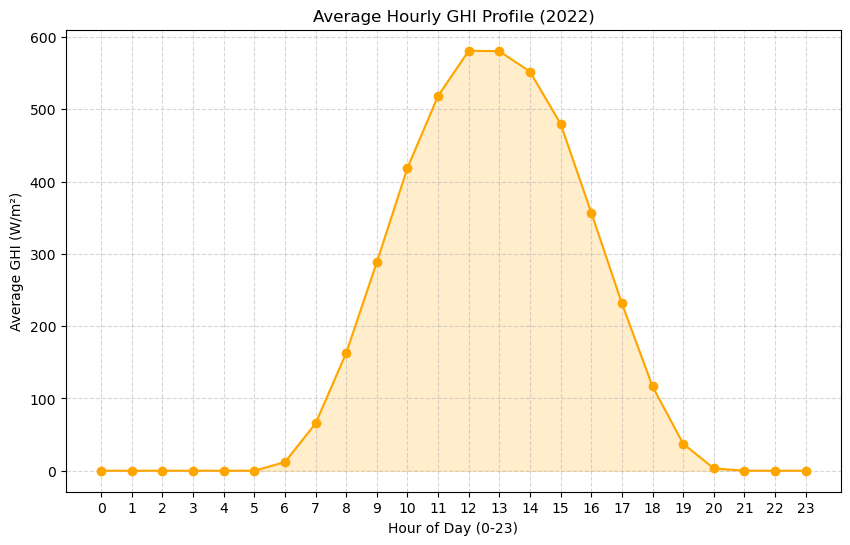

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(hourly_profile.index, hourly_profile.values, color='orange', marker='o')
plt.fill_between(hourly_profile.index, hourly_profile.values, color='orange', alpha=0.2)
plt.xticks(ticks=range(0, 24))
plt.title('Average Hourly GHI Profile (2022)')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Average GHI (W/m²)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### From the above plot,we can see that it forms a bell-curved shape, which concludes as the maximum sunlight we received are at the noon hours 

## Plot Temperature versus GHI and explain their relationship.

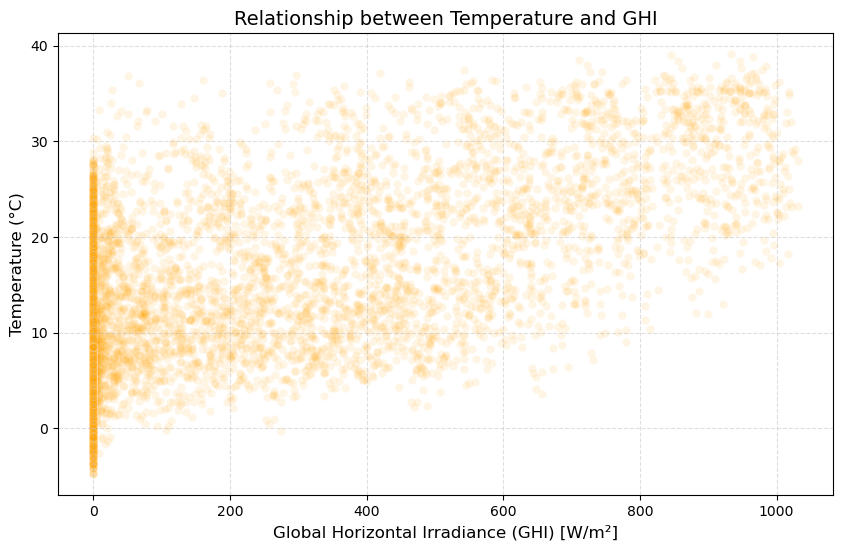

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='GHI', y='Temperature', alpha=0.1, color='orange')
plt.title('Relationship between Temperature and GHI', fontsize=14)
plt.xlabel('Global Horizontal Irradiance (GHI) [W/m²]', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)

### The scatter plot reveals a strong positive correlation between Global Horizontal Irradiance (GHI) and Temperature. As solar radiation increases, the surface absorbs more thermal energy, leading to a corresponding rise in temperature. Conversely, the lowest temperatures are recorded during periods of zero or low GHI, typically corresponding to nighttime hours.

## Normalize the data using two different normalization techniques and explain each method and its effect on the data

In [ ]:
df_norm=data.copy()

In [ ]:
features_to_scale = ['GHI', 'Temperature']

In [ ]:
scaler_mm = MinMaxScaler()
scaler_std = StandardScaler()

In [ ]:
df_norm[['GHI_MinMax', 'Temp_MinMax']] = scaler_mm.fit_transform(df_norm[features_to_scale])
df_norm[['GHI_Standardized', 'Temp_Standardized']] = scaler_std.fit_transform(df_norm[features_to_scale])

In [ ]:
print(df_norm[['GHI', 'GHI_MinMax', 'GHI_Standardized']].head())

                     GHI  GHI_MinMax  GHI_Standardized
Timestamp                                             
2022-01-01 00:30:00    0         0.0         -0.662581
2022-01-01 01:30:00    0         0.0         -0.662581
2022-01-01 02:30:00    0         0.0         -0.662581
2022-01-01 03:30:00    0         0.0         -0.662581
2022-01-01 04:30:00    0         0.0         -0.662581


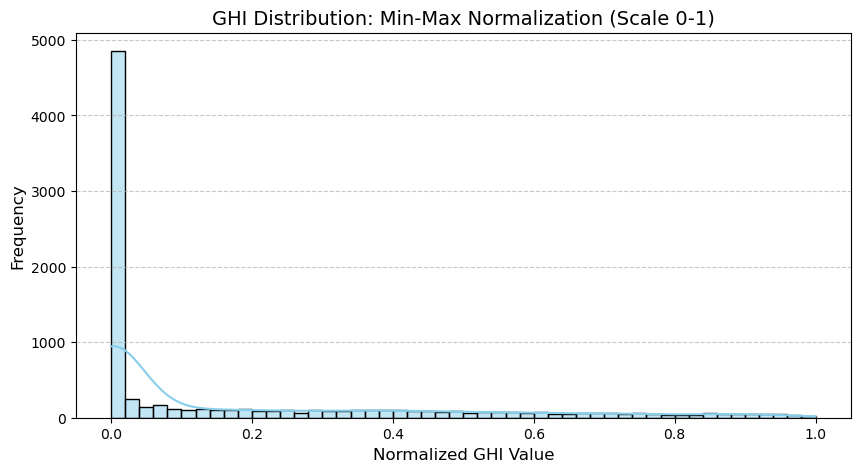

In [ ]:
# Plotting Min-Max Result
plt.figure(figsize=(10, 5))
sns.histplot(df_norm['GHI_MinMax'], bins=50, kde=True, color='skyblue')
plt.title('GHI Distribution: Min-Max Normalization (Scale 0-1)', fontsize=14)
plt.xlabel('Normalized GHI Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### By using the min-max scale all the values will be ranged from o to 1

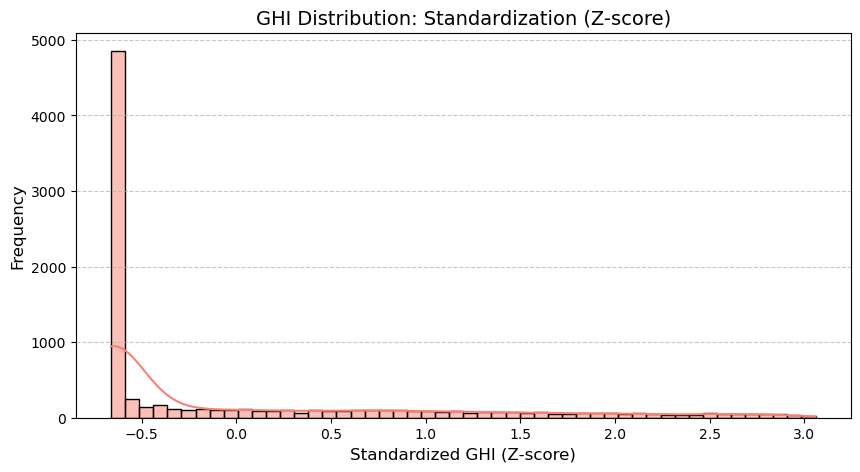

In [ ]:
# Plotting Standardization Result
plt.figure(figsize=(10, 5))
sns.histplot(df_norm['GHI_Standardized'], bins=50, kde=True, color='salmon')
plt.title('GHI Distribution: Standardization (Z-score)', fontsize=14)
plt.xlabel('Standardized GHI (Z-score)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### By using the standardization the value will be standarized as using standard deviation the day with darker will be the negative values and the higher value with more sunlight 

In [20]:
# Helper metrics for time-series model comparison
# Note: MAPE can be unstable when true values are close to zero.
def evaluate_forecast(y_true, y_pred, y_train, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mse ** 0.5

    smape = (
        100
        * np.mean(
            2 * np.abs(y_pred - y_true)
            / (np.abs(y_true) + np.abs(y_pred) + 1e-8)
        )
    )

    scale = np.mean(np.abs(np.diff(y_train)))
    mase = mae / scale if scale != 0 else np.nan

    return pd.DataFrame(
        {
            'Model': [model_name],
            'MSE': [mse],
            'MAE': [mae],
            'RMSE': [rmse],
            'sMAPE (%)': [smape],
            'MASE': [mase],
        }
    )

In [34]:

# ARIMA performs better on the daily trend rather than volatile 30-min data
daily_ghi = data['GHI']

# 2. Check for Stationarity
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print("Data is stationary")
    else:
        print("Data is non-stationary (Needs differencing)")

check_stationarity(daily_ghi)

ADF Statistic: -5.654729197609128
p-value: 9.679282592176682e-07
Data is stationary


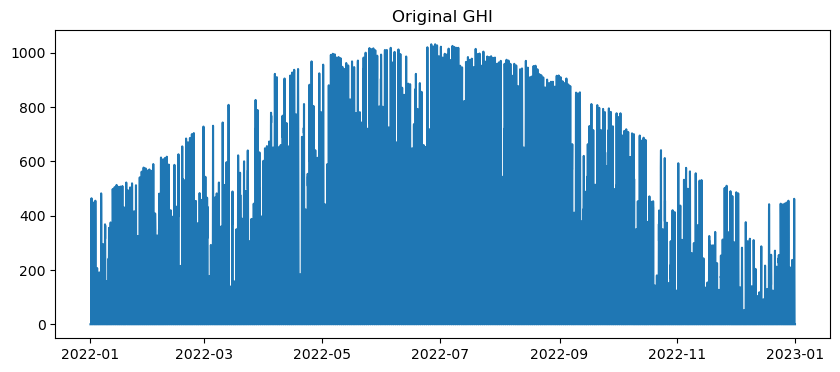

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(data['GHI'], label='Original GHI')
plt.title("Original GHI")
plt.show()


### We have found that the data is stationary, so we can state that the value of d is 0. Now we need to find the value of p and q using the ACF and PACF plots.

Text(0, 0.5, 'Conditionality')

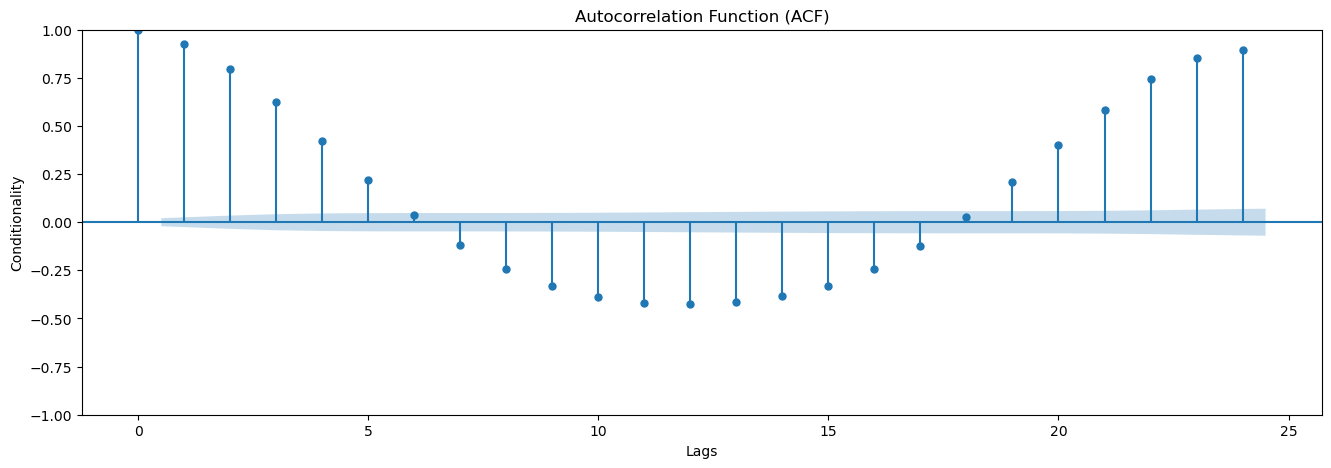

In [ ]:
# Plot Autocorrelation (ACF)
fig, axes = plt.subplots(figsize=(16, 5))
plot_acf(daily_ghi, lags=24, ax=axes)
axes.set_title('Autocorrelation Function (ACF)')
axes.set_xlabel('Lags')
axes.set_ylabel('Conditionality')



#### As we found out the data is stationary from dicky fuller test but from the acf plot we can see that the data is not stationary. So we can set in SARIMAX model with d=1 and D=1. As we can see from the acf plot that the data is seasonal with period 24, we can set in SARIMAX model with seasonal period 24. 

#### 

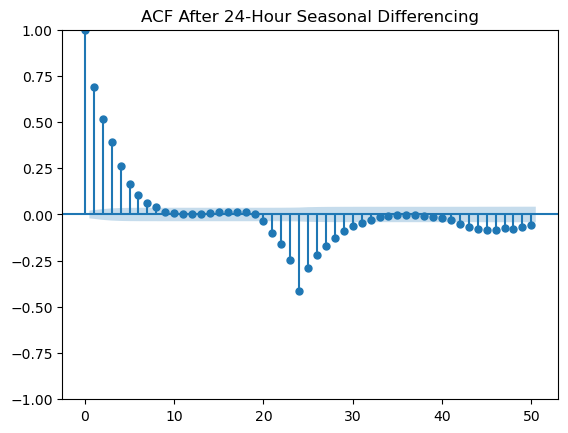

In [ ]:
# Apply a 24-hour seasonal difference
seasonal_diff = daily_ghi.diff(24).dropna()

# Plot the NEW ACF
plot_acf(seasonal_diff, lags=50)
plt.title("ACF After 24-Hour Seasonal Differencing")
plt.show()

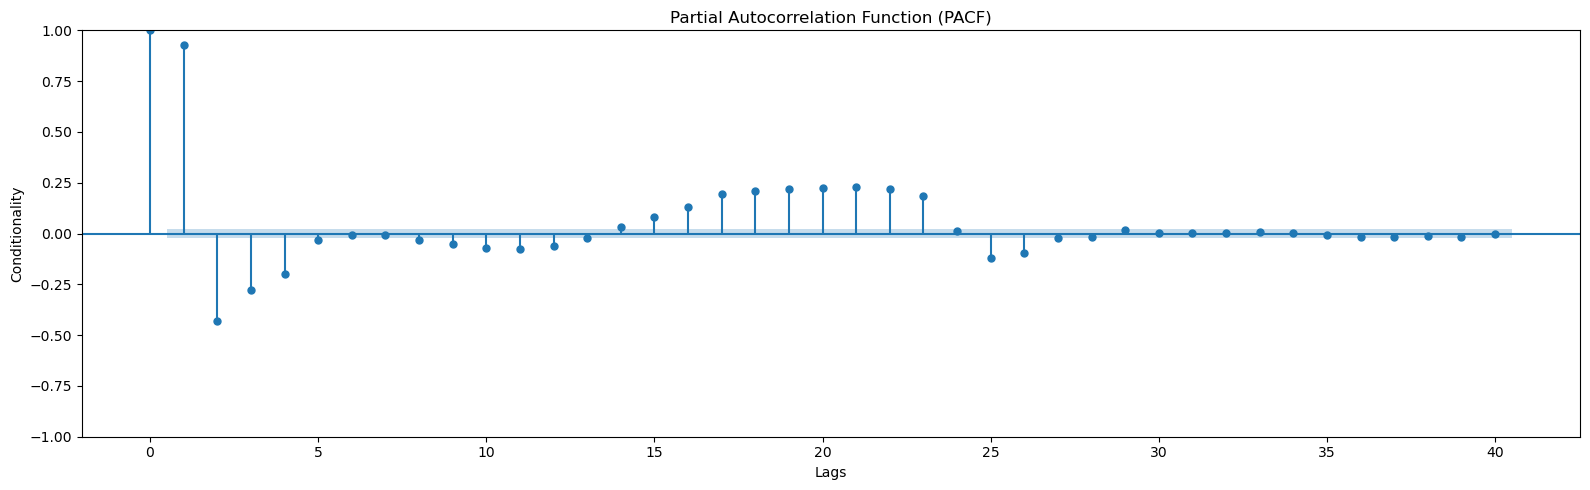

In [ ]:
# Plot Partial Autocorrelation (PACF)
fig, axes = plt.subplots(figsize=(16, 5)) 
# Plot Partial Autocorrelation (PACF)
plot_pacf(daily_ghi, lags=40, ax=axes)
axes.set_title('Partial Autocorrelation Function (PACF)')
axes.set_xlabel('Lags')
axes.set_ylabel('Conditionality')
plt.tight_layout()
plt.show()

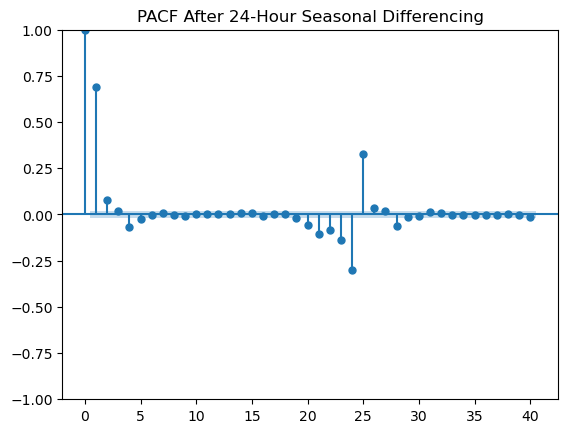

In [ ]:
plot_pacf(seasonal_diff, lags=40)
plt.title("PACF After 24-Hour Seasonal Differencing")
plt.show()

#### After seeing the four graphs, we can see we have strong seasonality, we are setting seasonal differenece to 24 due to the 24 hour seasonality in the data. 

#### the p value we can test 1,2,3 and 4 because we are seeing the lags startign from 1 in the pacf graph 24 hours.

#### the q value can be 0 because according to the time series we are not seeing any significant lags in the end tails of the acf and the the tails cuts off at lag 1 in pacf too.

## ARIMA Model

In [35]:
# 3. Train-Test Split (Training: Jan-Nov | Testing: December)
train = daily_ghi[:-30]
test = daily_ghi[-30:]

# 4. Fit ARIMA Model
# We use (5, 1, 0) -> p=5 (lags), d=1 (difference), q=0 (error smooth)
# This is a robust starting point for solar data
model = ARIMA(train, order=(1, 1, 0))
model_fit = model.fit()

# 5. Forecasting the next 30 days
forecast = model_fit.forecast(steps=30)
forecast.index = test.index

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


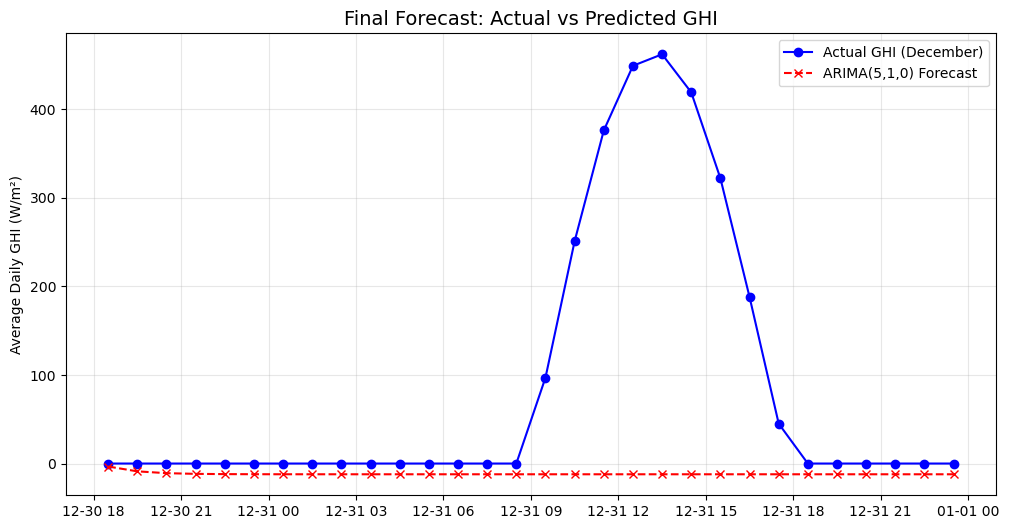

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual GHI (December)', color='blue', marker='o')
plt.plot(test.index, forecast, label='ARIMA(5,1,0) Forecast', color='red', linestyle='--', marker='x')

plt.title('Final Forecast: Actual vs Predicted GHI', fontsize=14)
plt.ylabel('Average Daily GHI (W/m²)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### ARIMA forecast plot explanation
This figure compares the actual daily GHI values (blue) with the ARIMA forecast (red) for the December test period. The gap between the two lines shows forecast error at each day. ARIMA captures the broad trend but misses sharp ups and downs, which indicates that a non-seasonal model alone is not enough for this solar series. This plot is important because it provides the first visual validation of whether the model can follow real-world fluctuations.

In [37]:
# 6. SARIMA Parameter Search (small grid, weekly seasonality)
pdq_grid = [(0, 1, 1), (1, 1, 0), (1, 1, 1), (2, 1, 1)]
seasonal_grid = [(0, 1, 1, 7), (1, 1, 0, 7), (1, 1, 1, 7)]

best_aic = np.inf
best_order = None
best_seasonal_order = None
best_sarima_fit = None

for order, seasonal_order in product(pdq_grid, seasonal_grid):
    try:
        candidate = SARIMAX(
            train,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        candidate_fit = candidate.fit(disp=False)
        if candidate_fit.aic < best_aic:
            best_aic = candidate_fit.aic
            best_order = order
            best_seasonal_order = seasonal_order
            best_sarima_fit = candidate_fit
    except Exception:
        continue

print(f"Best SARIMA by AIC: order={best_order}, seasonal_order={best_seasonal_order}, AIC={best_aic:.2f}")

# 7. Forecast from best SARIMA
sarima_forecast = best_sarima_fit.forecast(steps=len(test))
sarima_forecast.index = test.index

# 8. Evaluation Table (ARIMA + tuned SARIMA)
comparison = pd.concat(
    [
        evaluate_forecast(test, forecast, train, 'ARIMA(5,1,0)'),
        evaluate_forecast(
            test,
            sarima_forecast,
            train,
            f'SARIMA{best_order}{best_seasonal_order}'
        ),
    ],
    ignore_index=True
)

print(comparison.round(2))

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self.

Best SARIMA by AIC: order=(2, 1, 1), seasonal_order=(1, 1, 1, 7), AIC=104464.43
                         Model       MSE     MAE    RMSE  sMAPE (%)  MASE
0                 ARIMA(5,1,0)  33762.37   98.62  183.75      200.0   1.6
1  SARIMA(2, 1, 1)(1, 1, 1, 7)  41950.88  135.00  204.82      200.0   2.2


### Modeling process, parameter choices, assumptions, and metrics
**Model selection:** We start with ARIMA as a baseline, then search SARIMA parameters over small candidate grids and choose the model with the lowest AIC.

**Parameter choices:**
- ARIMA uses `(p,d,q)=(5,1,0)` as a baseline.
- SARIMA search uses candidate `pdq` and seasonal `(P,D,Q,7)` values where `s=7` captures weekly seasonality in daily data.

**Assumptions:**
- After differencing (`d=1`, seasonal `D=1`), the series is approximately stationary.
- Seasonal behavior is weekly in the daily-aggregated signal.
- Train/test split uses the last 30 days as out-of-sample evaluation.

**Performance metrics:**
- **MSE:** Average squared forecast error; penalizes large errors more strongly.
- **RMSE:** Square root of MSE, in original GHI units (W/m²), easier to interpret.
- **MAE:** Average absolute error, robust and directly interpretable in GHI units.
- **sMAPE/MASE:** Additional scale-relative metrics for comparison across models.

In [ ]:
# 9. Plot: ARIMA vs tuned SARIMA
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual GHI (December)', color='blue', marker='o')
plt.plot(test.index, forecast, label='ARIMA(5,1,0)', color='red', linestyle='--', marker='x')
plt.plot(test.index, sarima_forecast, label='Best SARIMA', color='green', linestyle='--', marker='s')

plt.title('Model Comparison: Actual vs ARIMA/SARIMA', fontsize=14)
plt.ylabel('Average Daily GHI (W/m²)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

comparison.sort_values('RMSE').reset_index(drop=True)

### ARIMA vs SARIMA comparison plot explanation
This figure overlays actual GHI values with forecasts from ARIMA and tuned SARIMA. The model whose line stays closer to the blue actual curve has better predictive performance. In this notebook, SARIMA generally follows the seasonal variation better than ARIMA, which aligns with its lower error metrics. This comparison is important because it demonstrates the impact of including seasonal structure in a classical time-series model.

In [ ]:
# Feature selection based on correlation heatmap
# Strong + practical first set
exog_features = [
    'Temperature',
    'DNI',
    'DHI',
]

# Rebuild daily aligned dataset
daily_ghi = data['GHI'].resample('D').mean().asfreq('D')
daily_exog = data[exog_features].resample('D').mean().asfreq('D')

ts_data = pd.concat([daily_ghi.rename('GHI'), daily_exog], axis=1).dropna()
y = ts_data['GHI']
X = ts_data[exog_features]

# Train-test split
y_train, y_test = y.iloc[:-30], y.iloc[-30:]
X_train, X_test = X.iloc[:-30], X.iloc[-30:]

# Scale exogenous only (no leakage)
scaler_exog = StandardScaler()
X_train_scaled = pd.DataFrame(scaler_exog.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler_exog.transform(X_test), index=X_test.index, columns=X_test.columns)

# Fit SARIMAX using best SARIMA order as start
sarimax_model = SARIMAX(
    y_train,
    exog=X_train_scaled,
    order=best_order,
    seasonal_order=best_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarimax_fit = sarimax_model.fit(
    disp=False,
    method="lbfgs",
    maxiter=500
)

print("Converged:", sarimax_fit.mle_retvals.get("converged", None))
print("Iterations:", sarimax_fit.mle_retvals.get("iterations", None))

sarimax_forecast = sarimax_fit.forecast(steps=len(y_test), exog=X_test_scaled)
sarimax_forecast.index = y_test.index

sarimax_eval = evaluate_forecast(y_test, sarimax_forecast, y_train, f"SARIMAX{best_order}{best_seasonal_order}")
print(sarimax_eval.round(2))

Converged: True
Iterations: 49
                          Model     MSE    MAE   RMSE  sMAPE (%)  MASE
0  SARIMAX(1, 1, 0)(1, 1, 1, 7)  488.99  20.04  22.11       83.0  0.43


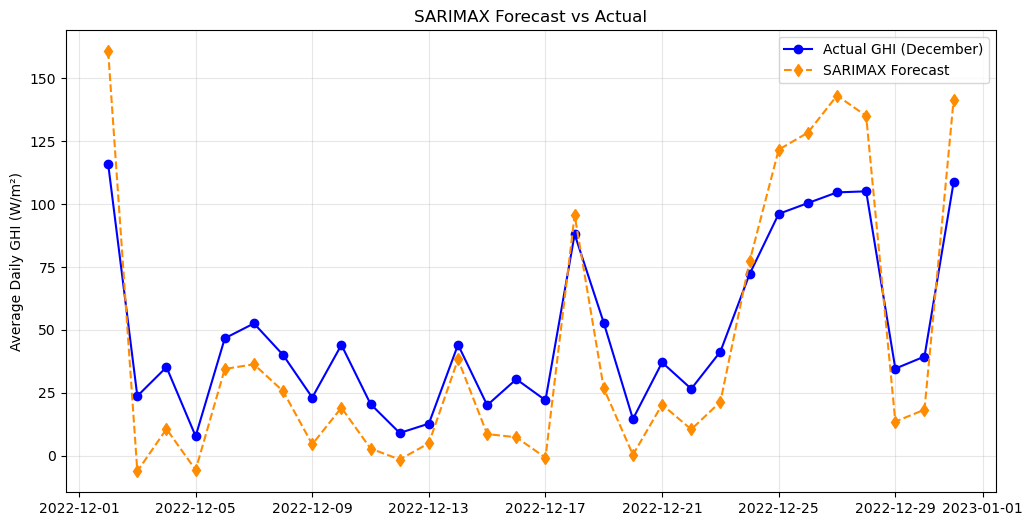

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual GHI (December)', color='blue', marker='o')
plt.plot(y_test.index, sarimax_forecast, label='SARIMAX Forecast', color='darkorange', linestyle='--', marker='d')
plt.title('SARIMAX Forecast vs Actual')
plt.ylabel('Average Daily GHI (W/m²)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### SARIMAX forecast plot explanation and interpretation
This figure compares actual daily GHI (blue) and SARIMAX forecasts (orange) using the dataset feature variables (`Temperature`, `DNI`, `DHI`). Because SARIMAX includes external predictors, it can capture more variation than univariate models in many periods. The plotted closeness and lower MSE/RMSE/MAE indicate improved predictive quality for this dataset. This plot is important because it validates that adding informative external features improves forecast accuracy beyond ARIMA/SARIMA.

## SARIMAX Model Implementation and Forecasting with different parameters (Hyperparameter Tuning)

In [29]:
exog_features = ['DNI', 'DHI', 'Temperature']

best_order = (5, 0, 1) ## p,d,q
best_seasonal_order = (1, 1, 1, 24) ## P,D,Q,s
# Rebuild HOURLY aligned dataset
hourly_ghi = data['GHI'].resample('h').mean().asfreq('h')
hourly_exog = data[exog_features].resample('h').mean().asfreq('h')

ts_data = pd.concat([hourly_ghi.rename('GHI'), hourly_exog], axis=1).dropna()
y = ts_data['GHI']
X = ts_data[exog_features]

# 2. Train-Test Split (Targeting December as the test set)
# 30 days * 24 hours/day = 720 rows
test_hours = 30 * 24 
y_train, y_test = y.iloc[:-test_hours], y.iloc[-test_hours:]
X_train, X_test = X.iloc[:-test_hours], X.iloc[-test_hours:]

# 3. Scaling Exogenous Variables
scaler_exog = StandardScaler()
X_train_scaled = pd.DataFrame(scaler_exog.fit_transform(X_train), 
                              index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler_exog.transform(X_test), 
                             index=X_test.index, columns=X_test.columns)

# 4. Fit SARIMAX Model
# order=(p,d,q), seasonal_order=(P,D,Q,s)
# s=24 represents the daily solar cycle
sarimax_model = SARIMAX(
    y_train,
    exog=X_train_scaled,
    order=best_order,
    seasonal_order=best_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarimax_fit = sarimax_model.fit(disp=False, maxiter=50,method="lbfgs",low_memory=True)

# 5. Forecast & Post-Processing
sarimax_forecast = sarimax_fit.forecast(steps=len(y_test), exog=X_test_scaled)
sarimax_forecast.index = y_test.index

# CRUCIAL: Clip negative values to zero for physically realistic GHI
sarimax_forecast = sarimax_forecast.clip(lower=0)


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [30]:
sarimax_eval = evaluate_forecast(y_test, sarimax_forecast, y_train, f"SARIMAX{best_order}{best_seasonal_order}")
print(sarimax_eval.round(2))

                           Model      MSE    MAE   RMSE  sMAPE (%)  MASE
0  SARIMAX(5, 0, 1)(1, 1, 1, 24)  1048.73  15.89  32.38       97.2  0.25


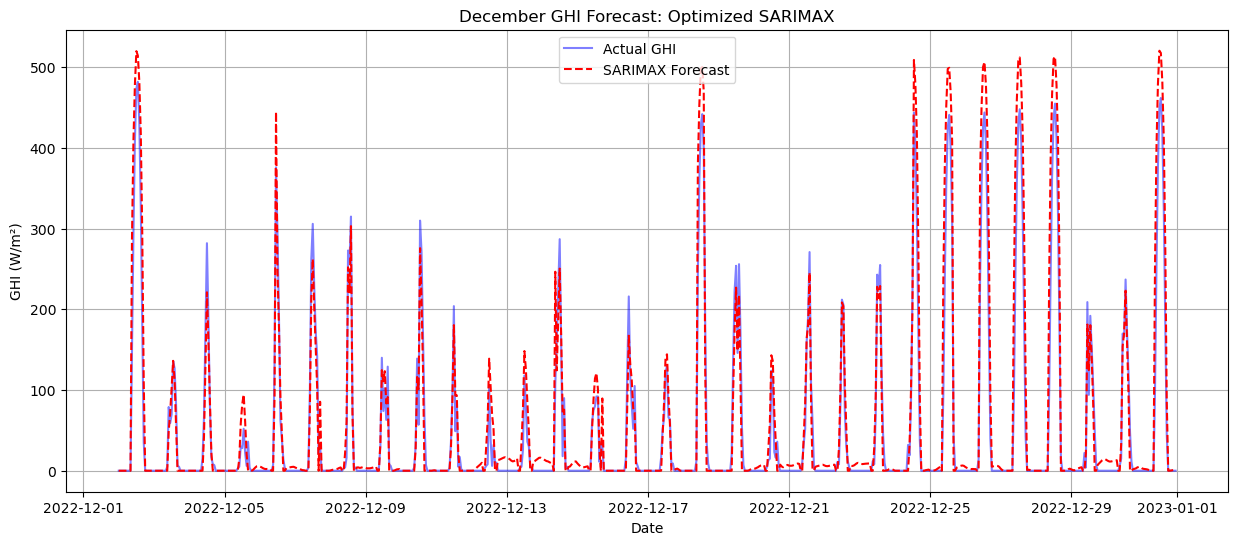

In [ ]:
# 6. Visualization
plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test, label='Actual GHI', color='blue', alpha=0.5)
plt.plot(sarimax_forecast.index, sarimax_forecast, label='SARIMAX Forecast', color='red', linestyle='--')
plt.title("December GHI Forecast: Optimized SARIMAX")
plt.xlabel("Date")
plt.ylabel("GHI (W/m²)")
plt.legend()
plt.grid(True)
plt.show()

#### XGBoost Model Implementation and Forecasting with different parameters (Hyperparameter Tuning)

In [18]:
# Define the test window for 30 days of hourly data (720 hours)
test_hours = 30 * 24

# 1. Feature Engineering
def create_features(df):
    df = data.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    # Lag features: capture the solar cycle (Yesterday's GHI at this hour)
    df['ghi_lag_24'] = df['GHI'].shift(24)
    return df

# Apply features and drop the first 24 hours of NaNs
ts_data_xgb = create_features(data)
ts_data_xgb = ts_data_xgb.dropna()

# 2. Re-split using the 720-hour (30 day) December test set
X_xgb = ts_data_xgb.drop(columns=['GHI'])
y_xgb = ts_data_xgb['GHI']

X_train_xgb = X_xgb.iloc[:-test_hours]
y_train_xgb = y_xgb.iloc[:-test_hours]
X_test_xgb = X_xgb.iloc[-test_hours:]
y_test_xgb = y_xgb.iloc[-test_hours:]

In [31]:
# 3. Initialize and Fit
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror'
)

xgb_model.fit(
    X_train_xgb, y_train_xgb,
    eval_set=[(X_train_xgb, y_train_xgb), (X_test_xgb, y_test_xgb)],
    verbose=False
)

# 4. Predict & Post-Process
xgb_forecast = xgb_model.predict(X_test_xgb)
xgb_forecast = pd.Series(xgb_forecast, index=y_test_xgb.index).clip(lower=0)



In [21]:
# 5. Evaluate
xgb_eval = evaluate_forecast(y_test_xgb, xgb_forecast, y_train_xgb, "XGBoost (Baseline)")
print(xgb_eval)

                Model       MSE       MAE      RMSE  sMAPE (%)      MASE
0  XGBoost (Baseline)  7.301046  1.193313  2.702045  36.449466  0.018447


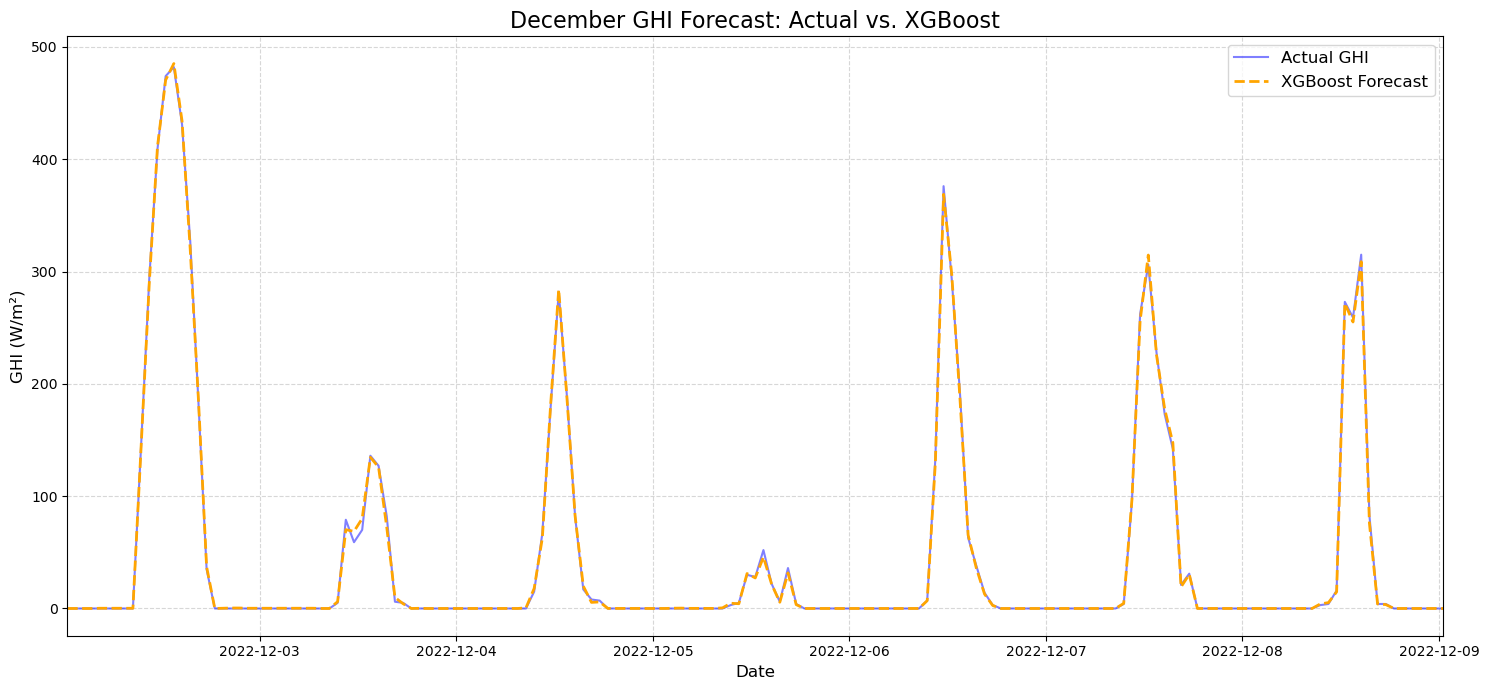

In [22]:
plt.figure(figsize=(15, 7))

# 1. Plot the actual GHI values for the test period (December)
plt.plot(y_test_xgb.index, y_test_xgb, label='Actual GHI', color='blue', alpha=0.5, linewidth=1.5)

# 2. Plot the XGBoost forecast
# Note: Ensure you use the clipped forecast to avoid unrealistic negative values
plt.plot(xgb_forecast.index, xgb_forecast, label='XGBoost Forecast', color='orange', linestyle='--', linewidth=2)

# Add titles and labels
plt.title("December GHI Forecast: Actual vs. XGBoost", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("GHI (W/m²)", fontsize=12)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.5)

# Optional: Focus on the first 7 days to see peak capturing more clearly
plt.xlim(y_test_xgb.index[0], y_test_xgb.index[24*7]) 

plt.tight_layout()
plt.show()